<a href="https://colab.research.google.com/github/simonUU/tf-playground/blob/master/VanillaGANwithBatchDiscriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla GAN with Batch Discriminator

In this notebook, we test an implementation of a vanilla GAN with an second batch discriminatior that should prohibit mode collaps.

We use an LSTM to have a binary classification over one batch in order to validate the diversity of the generator. 
For this the input images have to be shuffled.

### Comments
* The preliminary results are promising
* Execution time with second lstm are twice as long
* LR for the generator between D1 and D2 have to be adjusted/tuned

In [1]:
# lets load tf2.0
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 69kB/s 
     |████████████████████████████████| 61kB 25.6MB/s 
     |████████████████████████████████| 419kB 44.5MB/s 
     |████████████████████████████████| 3.0MB 43.2MB/s 


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [0]:
import tqdm
import time
import os 

from IPython import display
import matplotlib.pyplot as plt

In [0]:
# GLOBAL SETTING

BATCH_SIZE = 256
NOISE_DIM = 100

USE_BATCH_DISCRIMINATOR = True

## Load the data

In [6]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [14]:
train_images.shape

(60000, 28, 28, 1)

In [0]:
BUFFER_SIZE = train_images.shape[0]



In [0]:
# Use a tensorflow dataset

train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

## The generator

In [0]:
from tensorflow.keras import layers

def get_generator():
  # Total params: 1,818,112
  # Trainable params: 1,792,768
  # Non-trainable params: 25,344
  
  i = layers.Input(shape=(NOISE_DIM,))
  
  h = layers.Dense(7*7*256, use_bias=False)(i)
  h = layers.BatchNormalization()(h)
  h = layers.LeakyReLU()(h)

  h = layers.Reshape((7, 7, 256))(h)

  h = layers.Conv2DTranspose(64, (5,5), strides=(1,1),  use_bias=False)(h)
  h = layers.BatchNormalization()(h)
  h = layers.LeakyReLU()(h)

  h = layers.Conv2DTranspose(64, (5,5), strides=(2,2),  use_bias=False)(h)
  h = layers.BatchNormalization()(h)
  h = layers.LeakyReLU()(h)

  o = layers.Conv2DTranspose(1, (4,4), strides=(1,1),  use_bias=False, activation='tanh')(h)

  m = tf.keras.Model(i,o)
  return m

In [0]:

def get_generator2():
  # Total params: 1,818,112
  # Trainable params: 1,792,768
  # Non-trainable params: 25,344
  
  i = layers.Input(shape=(NOISE_DIM,))
  
  h = layers.Dense(7*7*256, use_bias=False)(i)
  h = layers.BatchNormalization()(h)
  h = layers.LeakyReLU()(h)

  h = layers.Reshape((7, 7, 256))(h)

  h = layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same',  use_bias=False)(h)
  h = layers.BatchNormalization()(h)
  h = layers.LeakyReLU()(h)

  h = layers.Conv2DTranspose(64, (5,5), strides=(2,2),  padding='same', use_bias=False)(h)
  h = layers.BatchNormalization()(h)
  h = layers.LeakyReLU()(h)

  o = layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')(h)

  m = tf.keras.Model(i,o)
  return m

Lets test the generator

In [0]:
G = get_generator()

noise = tf.random.normal([1,NOISE_DIM])
test_img = G(noise, training=False)

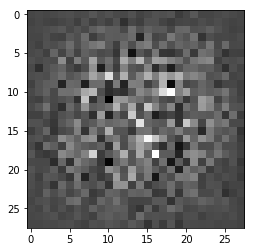

In [191]:
plt.imshow(test_img[0, :, :, 0], cmap='gray')


## The Discriminator(s)

In [0]:
def get_main_discriminator():
  
  i = layers.Input(shape=(28,28,1))

  h = layers.Conv2D(64, (5,5), strides=(2,2), padding='same')(i)
  h = layers.LeakyReLU()(h)
  h = layers.Dropout(0.3)(h)

  h = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(h)
  h = layers.LeakyReLU()(h)
  h = layers.Dropout(0.3)(h)

  h = layers.Flatten()(h)
  h = layers.Dense(1)(h)

  m = tf.keras.Model(i,h)
  return m

In [193]:
D1 = get_main_discriminator()
decision = D1(test_img)
print(decision)

tf.Tensor([[0.00252793]], shape=(1, 1), dtype=float32)


In [194]:
bm.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 7, 7, 128)         0  

In [0]:
def get_batch_discriminator():
  #     Total params: 292,097
  #   Trainable params: 292,097
  #   Non-trainable params: 0

  i = layers.Input(shape=(BATCH_SIZE, 28,28,1))
  
  h = layers.Reshape(( BATCH_SIZE, 28*28 ))(i)
#   h = layers.Dense(10)(h)
  h = layers.LSTM(10)(h)

  h = layers.Dense(1)(h)

  m = tf.keras.Model(i,h)
  return m

In [302]:
D2 = get_batch_discriminator()

W0430 12:56:53.348661 140687815636864 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ff20976dc50>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [303]:
D2.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 256, 28, 28, 1)]  0         
_________________________________________________________________
reshape_37 (Reshape)         (None, 256, 784)          0         
_________________________________________________________________
unified_lstm_10 (UnifiedLSTM (None, 10)                31800     
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 11        
Total params: 31,811
Trainable params: 31,811
Non-trainable params: 0
_________________________________________________________________


## The Loss Functions

In [0]:
# Discriminator 1 loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_outputs, fake_outputs):
  real_loss = cross_entropy(tf.ones_like(real_outputs), real_outputs)
  fake_loss = cross_entropy(tf.zeros_like(fake_outputs), fake_outputs)
  return real_loss + fake_loss


In [0]:
# Generator loss

def generator_loss(fake_outputs):
  return cross_entropy(tf.ones_like(fake_outputs), fake_outputs)

In [0]:
# optimizers

gen_optimizer = tf.keras.optimizers.Adam(0.0001)
dis1_optimizer = tf.keras.optimizers.Adam(0.0001)
dis2_optimizer = tf.keras.optimizers.Adam(0.0001)

In [0]:
# Save checkpoints (taken from tf examples)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=dis1_optimizer,
                                 generator=G,
                                 discriminator=D1)


## Prepare the training

In [0]:
EPOCHS = 50
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])


In [0]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
  
  if images.shape != [BATCH_SIZE, 28, 28, 1]:
    return
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as gen_tape_batch, tf.GradientTape() as dis_tape, tf.GradientTape() as dis_tape_batch:
    generated_images = G(noise, training=True)
    
    # Vanilla
    real_output = D1(images, training=True)
    fake_output = D1(generated_images, training=True)
    
    gen_loss = generator_loss(fake_output)
    dis1_loss = discriminator_loss(real_output, fake_output)
    
    if USE_BATCH_DISCRIMINATOR:
      # LSTM on Batch
      assert images.shape == [BATCH_SIZE, 28, 28, 1], print("Shape not matched ", images.shape)
      real_output_batch = D2(tf.reshape(images, (1, BATCH_SIZE, 28, 28, 1)), training=True)
      fake_output_batch = D2(tf.reshape(generated_images, (1, BATCH_SIZE, 28, 28, 1)), training=True)

    gen_loss_batch = generator_loss(fake_output_batch)
    dis2_loss = discriminator_loss(real_output_batch, fake_output_batch)
  
  # Vanilla
  gradients_gen = gen_tape.gradient(gen_loss, G.trainable_variables)
  gradients_dis1 = dis_tape.gradient(dis1_loss, D1.trainable_variables)
  
  gen_optimizer.apply_gradients(zip(gradients_gen, G.trainable_variables))
  dis1_optimizer.apply_gradients(zip(gradients_dis1, D1.trainable_variables))

  if USE_BATCH_DISCRIMINATOR:
    # LSTM on Batch
    gradients_gen_batch = gen_tape_batch.gradient(gen_loss_batch, G.trainable_variables)
    gradients_dis2 = dis_tape_batch.gradient(dis2_loss, D2.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_gen_batch, G.trainable_variables))
    dis2_optimizer.apply_gradients(zip(gradients_dis2, D2.trainable_variables))

In [0]:
#vvvvv Taken from tf tutorial vvvvvv
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [0]:
def train(dataset, epochs):
  for ep in tqdm.trange(epochs, desc='Epoch Loop'):
    
#     for batch in tqdm.tqdm(dataset, desc='Inner Epoch Loop',):
    for batch in dataset:
      start = time.time()

      train_step(batch)
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(G, ep + 1, seed)

    if (ep + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(ep+ 1, time.time()-start))
        
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(G,epochs,seed)


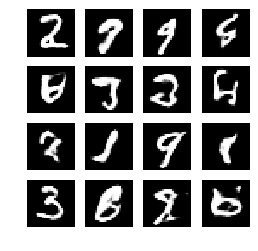



















Epoch Loop:  38%|███▊      | 19/50 [06:11<09:58, 19.32s/it]

Time for epoch 19 is 0.7046422958374023 sec


KeyboardInterrupt: ignored

In [343]:
train(train_dataset, EPOCHS)
